# Introduction: 

Traffic accidents are a major public safety concern in the United States, resulting in thousands of fatalities and injuries each year. Examining the underlying causes and identifying trends in accident occurrence are important steps towards making roads safer for everyone. The US Accidents dataset, which was developed by Sobhan Moosavi on Kaggle, is a treasure trove of information for conducting such analyses.


## Dataset Description
This dataset contains over 4 million records of traffic accidents that occurred across the United States between 2016 and 2023. It was collected primarily through various APIs that aggregate data from sources such as traffic sensors, government reports, weather data providers, and user-generated content from apps like MapQuest. The dataset contains a wide range of features about:
- Time and location of accidents (state, city, latitude/longitude)
- Environment conditions (weather, visibility, temperature, humidity)
- Traffic and road features (street name, side of the road, traffic signals)
- Accident characteristics (severity, distance, number of lanes affected)
- Temporal trends (hour, day of week, month)


## Goals of the US Accidents Dataset Analysis
Given the breadth and depth of this dataset, it provides an excellent foundation for exploring several key questions related to traffic safety and risk. The primary goals of this analysis include:
- Understanding factors that contribute to traffic accidents
- Building a predictive model for accident severity
- Identifying high-risk locations or conditions
- Creating visualizations of accident patterns
- Providing insights that could help reduce accidents


Through this comprehensive analysis, we aim to not only derive meaningful insights from historical data but also contribute to smarter infrastructure planning and more proactive safety strategies in the future.




# Setting Up PySpark

In [1]:
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q https://dlcdn.apache.org/spark/spark-3.5.5/spark-3.5.5-bin-hadoop3.tgz
# !tar xf spark-3.5.5-bin-hadoop3.tgz
# !pip install -q findspark

# Libraries

In [2]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import Imputer, StringIndexer, OneHotEncoder, VectorAssembler

# Loading Data

In [3]:
spark = SparkSession.builder \
    .appName("US Accidents Analysis") \
    .config("spark.driver.memory", "6g") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

25/04/11 20:02:52 WARN Utils: Your hostname, lenovo-server resolves to a loopback address: 127.0.1.1; using 192.168.100.30 instead (on interface eno1)
25/04/11 20:02:52 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/11 20:02:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/11 20:02:53 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


We have increased the amount of resources to have better performance

In [4]:
df = spark.read.format("csv") \
    .option("header", "True") \
    .option("inferSchema", "True") \
    .load("US_Accidents_March23.csv")

25/04/11 20:03:07 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


Reads US_Accidents_March23.csv into a Spark DataFrame (df), using the first row as headers and inferring column types automatically.

In [5]:
df.printSchema()

root
 |-- ID: string (nullable = true)
 |-- Source: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- End_Lat: double (nullable = true)
 |-- End_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- Description: string (nullable = true)
 |-- Street: string (nullable = true)
 |-- City: string (nullable = true)
 |-- County: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zipcode: string (nullable = true)
 |-- Country: string (nullable = true)
 |-- Timezone: string (nullable = true)
 |-- Airport_Code: string (nullable = true)
 |-- Weather_Timestamp: timestamp (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Wind_Chill(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- V

In [6]:
df.show(5)

25/04/11 20:03:08 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+---+-------+--------+-------------------+-------------------+-----------------+------------------+-------+-------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|End_Lat|End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Weather_Condition|Ameni

In [7]:
print(f"Total number of records: {df.count()}")
print(f"Number of columns: {len(df.columns)}")
print("Column names:", df.columns)

Total number of records: 7728394
Number of columns: 46
Column names: ['ID', 'Source', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']


# Data preprocess and clean

In [8]:
print("Missing values per column:")
for column_name, dtype in df.dtypes:
    if dtype in ("int", "double", "float"):
        # For numeric columns, check for nulls and NaN values
        missing_count = df.filter(F.col(column_name).isNull() | F.isnan(column_name)).count()
    else:
        # For non-numeric columns, only check for nulls and empty strings
        missing_count = df.filter(F.col(column_name).isNull() | (F.col(column_name) == "")).count()
    
    print(f"{column_name}: {missing_count}")

Missing values per column:


ID: 0


Source: 0


Severity: 0


Start_Time: 0


End_Time: 0


Start_Lat: 0


Start_Lng: 0


End_Lat: 3402762


End_Lng: 3402762


Distance(mi): 0


Description: 5


Street: 10869


City: 253


County: 0


State: 0


Zipcode: 1915


Country: 0


Timezone: 7808


Airport_Code: 22635


Weather_Timestamp: 120228


Temperature(F): 163853


Wind_Chill(F): 1999019


Humidity(%): 174144


Pressure(in): 140679


Visibility(mi): 177098


Wind_Direction: 175206


Wind_Speed(mph): 571233


Precipitation(in): 2203586


Weather_Condition: 173459


Amenity: 0


Bump: 0


Crossing: 0


Give_Way: 0


Junction: 0


No_Exit: 0


Railway: 0


Roundabout: 0


Station: 0


Stop: 0


Traffic_Calming: 0


Traffic_Signal: 0


Turning_Loop: 0


Sunrise_Sunset: 23246


Civil_Twilight: 23246


Nautical_Twilight: 23246


Astronomical_Twilight: 23246


# Dealing with missing values

## End_Lat and End_Lng Missing values

For End_Lat and End_Lng: Assuming, these are likely accidents where the endpoint wasn't recorded


Dropping these columns, fill with Start_Lat/Start_Lng, or keep nulls

In [9]:
df = df.withColumn("End_Lat", F.when(F.col("End_Lat").isNull(), F.col("Start_Lat")).otherwise(F.col("End_Lat")))
df = df.withColumn("End_Lng", F.when(F.col("End_Lng").isNull(), F.col("Start_Lng")).otherwise(F.col("End_Lng")))

##  Weather-related columns Missing Values

### Numeric

We have options:
- Fill with mean/median (for numeric data)
- Fill with a special value indicating "unknown"
- Leave as null for downstream processing

In [10]:
weather_numeric_cols = ["Temperature(F)", "Wind_Chill(F)", "Humidity(%)", 
                        "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", 
                        "Precipitation(in)"]

for col in weather_numeric_cols:
    # Calculate mean excluding null values
    mean_val = df.select(F.mean(col)).collect()[0][0]
    # Replace nulls with the mean
    df = df.withColumn(col, F.when(F.col(col).isNull(), mean_val).otherwise(F.col(col)))

### Categorical

For categorical weather data, replacing missing with "Unknown"

In [11]:
df = df.withColumn("Weather_Condition", 
                  F.when(F.col("Weather_Condition").isNull(), "Unknown")
                   .otherwise(F.col("Weather_Condition")))

df = df.withColumn("Wind_Direction", 
                  F.when(F.col("Wind_Direction").isNull(), "Unknown")
                   .otherwise(F.col("Wind_Direction")))

## Twilight-related columns Missing Values

Filling with most frequent value

In [12]:
twilight_cols = ["Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", "Astronomical_Twilight"]
for col in twilight_cols:
    # Fill with most frequent value
    most_common = df.groupBy(col).count().orderBy("count", ascending=False).first()[0]
    df = df.withColumn(col, F.when(F.col(col).isNull(), most_common).otherwise(F.col(col)))

## Other location based and description

- Uses Spark's F.when(F.col(column).isNull(), replacement_value) to check for nulls.

- otherwise(F.col(column)) retains original non-null values.

In [13]:
df = df.withColumn("Street", F.when(F.col("Street").isNull(), "Unknown").otherwise(F.col("Street")))
df = df.withColumn("City", F.when(F.col("City").isNull(), "Unknown").otherwise(F.col("City")))
df = df.withColumn("Zipcode", F.when(F.col("Zipcode").isNull(), "Unknown").otherwise(F.col("Zipcode")))
df = df.withColumn("Airport_Code", F.when(F.col("Airport_Code").isNull(), "Unknown").otherwise(F.col("Airport_Code")))
df = df.withColumn("Timezone", F.when(F.col("Timezone").isNull(), "Unknown").otherwise(F.col("Timezone")))
df = df.withColumn("Description", F.when(F.col("Description").isNull(), "No description provided").otherwise(F.col("Description")))

## Missing Weather_Timestamp with Start_Time

- Checks if Weather_Timestamp is null using F.col("Weather_Timestamp").isNull().
- If null, replaces it with the value from Start_Time.
- Otherwise, keeps the original Weather_Timestamp value.

In [14]:
df = df.withColumn("Weather_Timestamp", 
                  F.when(F.col("Weather_Timestamp").isNull(), F.col("Start_Time"))
                   .otherwise(F.col("Weather_Timestamp")))

## After Clean

In [15]:
print("Missing values after cleaning:")
for column_name in df.columns:
    missing_count = df.filter(F.col(column_name).isNull()).count()
    print(f"{column_name}: {missing_count}")

Missing values after cleaning:


ID: 0


Source: 0


Severity: 0


Start_Time: 0


End_Time: 0


Start_Lat: 0


Start_Lng: 0


End_Lat: 0


End_Lng: 0


Distance(mi): 0


Description: 0


Street: 0


City: 0


County: 0


State: 0


Zipcode: 0


Country: 0


Timezone: 0


Airport_Code: 0


Weather_Timestamp: 0


Temperature(F): 0


Wind_Chill(F): 0


Humidity(%): 0


Pressure(in): 0


Visibility(mi): 0


Wind_Direction: 0


Wind_Speed(mph): 0


Precipitation(in): 0


Weather_Condition: 0


Amenity: 0


Bump: 0


Crossing: 0


Give_Way: 0


Junction: 0


No_Exit: 0


Railway: 0


Roundabout: 0


Station: 0


Stop: 0


Traffic_Calming: 0


Traffic_Signal: 0


Turning_Loop: 0


Sunrise_Sunset: 0


Civil_Twilight: 0


Nautical_Twilight: 0


Astronomical_Twilight: 0


In [16]:
df.show(5)

+---+-------+--------+-------------------+-------------------+-----------------+------------------+-----------------+------------------+------------+--------------------+--------------------+------------+----------+-----+----------+-------+----------+------------+-------------------+--------------+-----------------+-----------+------------+--------------+--------------+-----------------+--------------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+--------------+-----------------+---------------------+
| ID| Source|Severity|         Start_Time|           End_Time|        Start_Lat|         Start_Lng|          End_Lat|           End_Lng|Distance(mi)|         Description|              Street|        City|    County|State|   Zipcode|Country|  Timezone|Airport_Code|  Weather_Timestamp|Temperature(F)|    Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|  

## Check for duplicated rows

We don't have any duplicates in the dataset

In [17]:
# Count total rows
total_rows = df.count()

# Count distinct rows
distinct_rows = df.dropDuplicates().count()

# Calculate number of duplicate rows
duplicate_count = total_rows - distinct_rows

print(f"Total rows: {total_rows}")
print(f"Distinct rows: {distinct_rows}")
print(f"Duplicate rows: {duplicate_count}")


Total rows: 7728394
Distinct rows: 7728394
Duplicate rows: 0


## Check for possible outliers

In [18]:
numeric_columns = [col for col, dtype in df.dtypes if dtype in ("int", "double", "float")]

print("Outliers per numeric column (using IQR method):")
for column in numeric_columns:
    # Compute Q1 and Q3 using Spark's approxQuantile (fast + scalable)
    quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)

    if len(quantiles) < 2:
        print(f"{column}: Skipping (not enough data)")
        continue

    Q1, Q3 = quantiles
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Filter outliers
    outlier_count = df.filter((F.col(column) < lower_bound) | (F.col(column) > upper_bound)).count()

    print(f"{column}: {outlier_count} outliers")

Outliers per numeric column (using IQR method):


Severity: 1571413 outliers


Start_Lat: 0 outliers


Start_Lng: 0 outliers


End_Lat: 0 outliers


End_Lng: 0 outliers


Distance(mi): 1079392 outliers


Temperature(F): 75757 outliers


Wind_Chill(F): 395164 outliers


Humidity(%): 0 outliers


Pressure(in): 419070 outliers


Visibility(mi): 1658163 outliers


Wind_Speed(mph): 291148 outliers


Precipitation(in): 308072 outliers


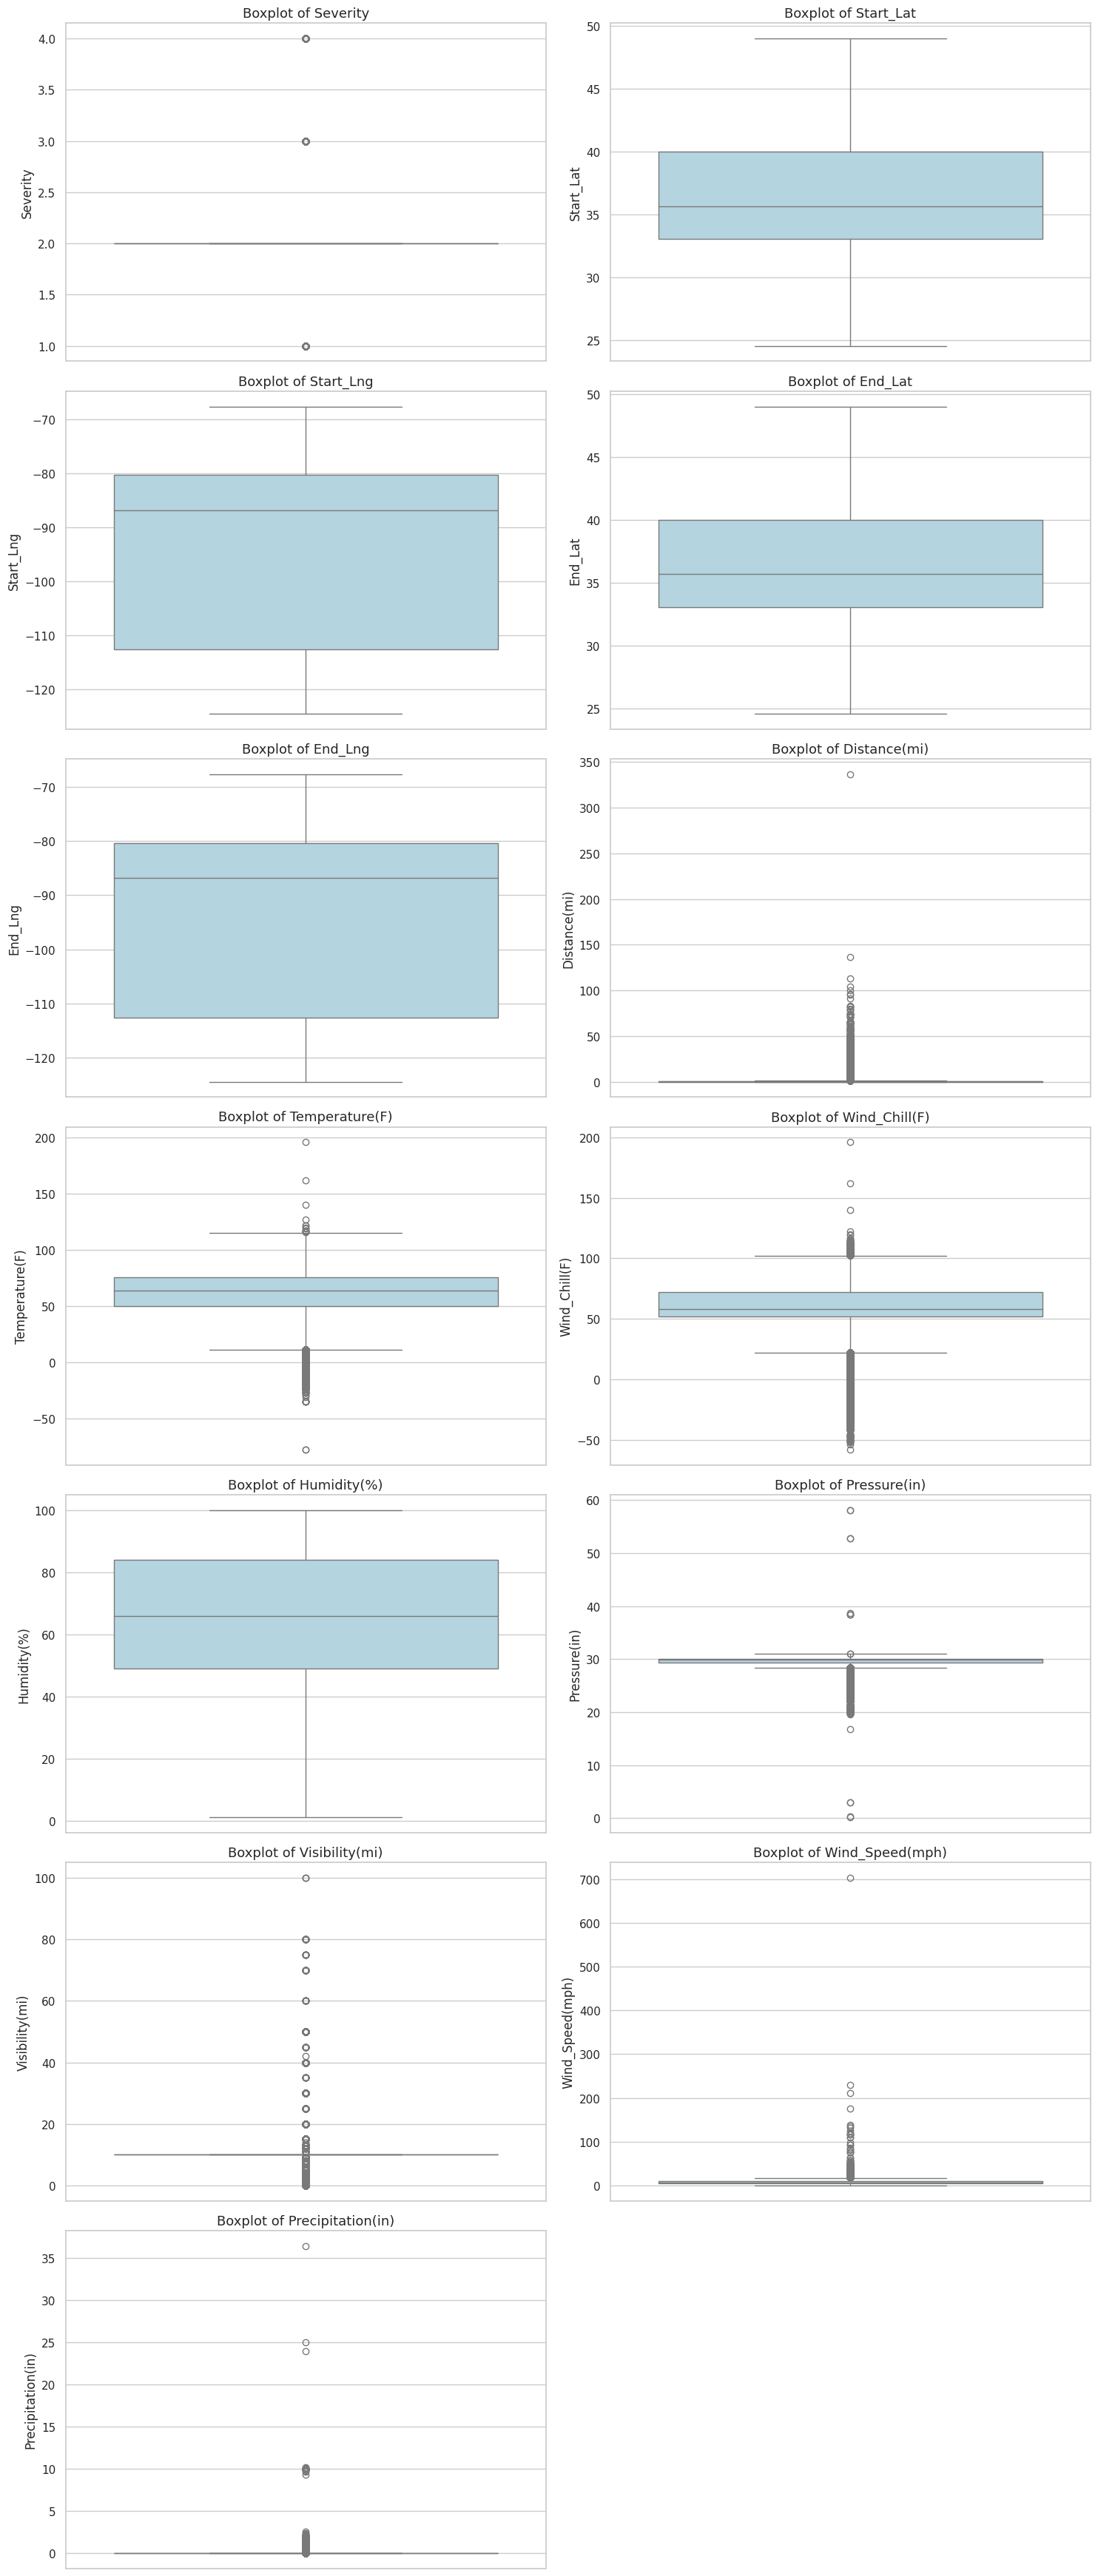

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Get numeric columns from Spark DataFrame
numeric_columns = [col for col, dtype in df.dtypes if dtype in ("int", "double", "float")]

# Sample and collect to Pandas
sample_df = df.select(numeric_columns)
pandas_df = sample_df.toPandas()

# Set style
sns.set(style="whitegrid")

# Layout: 2 plots per row
n_cols = 2
valid_columns = [col for col in numeric_columns if pandas_df[col].dropna().nunique() > 1]
n_rows = (len(valid_columns) + 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.flatten()

# Plot each valid column
for i, col in enumerate(valid_columns):
    sns.boxplot(y=pandas_df[col], ax=axes[i], color='lightblue')
    axes[i].set_title(f'Boxplot of {col}', fontsize=13)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


The outliers tend to appear due to the follwing reasons:
- Since the data is too large then we tend to have a high density around the mean, resulting in a high kurtosis and therefore higher outlier sensitivity
- Seasonality and location also affect the outliers since we have some unusualy wether observation that happends in overseas part of the US or in extreme weather condidtionss. 

# Data Preprocessing

In [20]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler

This classification is crucial because each data type requires different preprocessing approaches.

In [21]:
categorical_cols = [
    "Source", "Severity", "State", "Country", "Timezone", "Weather_Condition", 
    "Wind_Direction", "Sunrise_Sunset", "Civil_Twilight", "Nautical_Twilight", 
    "Astronomical_Twilight"
]

boolean_cols = [
    "Amenity", "Bump", "Crossing", "Give_Way", "Junction", "No_Exit", 
    "Railway", "Roundabout", "Station", "Stop", "Traffic_Calming", 
    "Traffic_Signal", "Turning_Loop"
]

numerical_cols = [
    "Start_Lat", "Start_Lng", "End_Lat", "End_Lng", "Distance(mi)", 
    "Temperature(F)", "Wind_Chill(F)", "Humidity(%)", "Pressure(in)", 
    "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"
]

**Step 1: String Indexing**

This creates a collection of StringIndexer transformers that:
- Convert each text value in categorical columns to a numerical index
- Assign indices based on frequency (most frequent value gets index 0)
- Create new columns with suffix "_idx" containing these numerical indices
- Handle invalid or unseen values gracefully with the "keep" option

In [22]:
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_idx", handleInvalid="keep") 
            for col in categorical_cols]

**Step 2: One-Hot Encoding**

This step transforms the indexed values into one-hot encoded vectors:
- Each category becomes a sparse vector (mostly zeros with a single 1)
- The vector length equals the number of unique values in the category
- The resulting columns have suffix "_ohe" (one-hot encoded)
- This transformation is essential as most ML algorithms cannot directly process categorical data

In [23]:
encoders = [OneHotEncoder(inputCol=f"{col}_idx", outputCol=f"{col}_ohe") 
            for col in categorical_cols]

**Feature Vector Creation**

**Step 3: Feature Column Collection**


This collects all processed feature column names that will be used to build the final feature vector:
- One-hot encoded categorical columns
- Original numerical columns
- Original boolean columns (already in 0/1 format)

In [24]:
feature_cols = [f"{col}_ohe" for col in categorical_cols] + numerical_cols + boolean_cols

**Step 4: Vector Assembly**

The VectorAssembler:
- Takes all individual feature columns
- Combines them into a single dense or sparse vector
- Creates a new column called "features" containing these vectors
- Properly handles any invalid values

In [25]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features", handleInvalid="keep")

**Feature Standardization**


This transformer standardizes the assembled feature vectors by:
- Subtracting the mean from each feature
- Dividing by the standard deviation
- Producing a new column "scaled_features" with standardized values
- Ensuring all features contribute equally to model learning regardless of their original scale

In [26]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

**Pipeline Construction**

The Pipeline combines all preprocessing steps into a single workflow:
1. all string indexers to convert categories to numbers
2. all one-hot encoders to convert numbers to vectors
3. Assemble all features into a single vector
4. Scale the assembled vector

This ensures transformations are applied in the correct order and simplifies deployment.

In [27]:
from pyspark.ml import Pipeline

preprocessing_pipeline = Pipeline(stages=indexers + encoders + [assembler, scaler])
preprocessed_data = preprocessing_pipeline.fit(df).transform(df)
preprocessed_data.select("features", "scaled_features").show(5, truncate=True)

+--------------------+--------------------+
|            features|     scaled_features|
+--------------------+--------------------+
|(265,[1,4,25,56,5...|(265,[1,4,25,56,5...|
|(265,[1,3,25,56,5...|(265,[1,3,25,56,5...|
|(265,[1,3,25,56,5...|(265,[1,3,25,56,5...|
|(265,[1,4,25,56,5...|(265,[1,4,25,56,5...|
|(265,[1,3,25,56,5...|(265,[1,3,25,56,5...|
+--------------------+--------------------+
only showing top 5 rows



# Feature Engineering

In [28]:
from pyspark.sql.functions import hour, dayofweek, month, year
from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.stat import Correlation

## Time Based Features

In [29]:
df_fe = preprocessed_data.withColumn("Hour", hour(F.col("Start_Time")))
df_fe = df_fe.withColumn("DayOfWeek", dayofweek(F.col("Start_Time")))
df_fe = df_fe.withColumn("Month", month(F.col("Start_Time")))
df_fe = df_fe.withColumn("Year", year(F.col("Start_Time")))

Extracts temporal features from Start_Time for analysis.

New Features Created:
- Hour (0-23)
- DayOfWeek (1-7, where 1=Sunday)
- Month (1-12)
- Year (e.g., 2016)

## Distance-based features

In [30]:
df_fe = df_fe.withColumn("Is_Long_Distance", F.when(F.col("Distance(mi)") > 5, 1).otherwise(0))

create the binary feature "Is_Long_Distance" where 1 indicated yes and  indicate no.

## Weather severity feature

In [31]:
df_fe = df_fe.withColumn("Poor_Visibility", F.when(F.col("Visibility(mi)") < 5, 1).otherwise(0))
df_fe = df_fe.withColumn("Extreme_Temp", 
                         F.when((F.col("Temperature(F)") > 90) | (F.col("Temperature(F)") < 32), 1).otherwise(0))

- Poor_Visibility binary feature to tell if the visiblity is poor (less than 5 miles) or fine.
- Extreme_Temp indicate how severe is the weather - between 90 and 32 f is considered to be fine.

## Updating

In [32]:
new_numerical_cols = ["Hour", "DayOfWeek", "Month", "Year", "Is_Long_Distance", 
                      "Poor_Visibility", "Extreme_Temp"]

all_features = feature_cols + new_numerical_cols
new_assembler = VectorAssembler(inputCols=all_features, outputCol="features_engineered", handleInvalid="keep")

df_fe = new_assembler.transform(df_fe)

In [33]:
df_fe.select("Hour", "DayOfWeek", "Month", "Year", "Is_Long_Distance","Poor_Visibility", "Extreme_Temp").show(5, truncate=True)

+----+---------+-----+----+----------------+---------------+------------+
|Hour|DayOfWeek|Month|Year|Is_Long_Distance|Poor_Visibility|Extreme_Temp|
+----+---------+-----+----+----------------+---------------+------------+
|   5|        2|    2|2016|               0|              0|           0|
|   6|        2|    2|2016|               0|              0|           0|
|   6|        2|    2|2016|               0|              0|           0|
|   7|        2|    2|2016|               0|              0|           0|
|   7|        2|    2|2016|               0|              0|           0|
+----+---------+-----+----+----------------+---------------+------------+
only showing top 5 rows



- Created time-based features (Hour, DayOfWeek, Month, Year)
- Derived distance-based features (Is_Long_Distance)
- Generated weather severity indicators (Poor_Visibility, Extreme_Temp)
- Assembled engineered features into a comprehensive feature vector
- Performed feature selection to identify most important predictors
- Analyzed feature correlations to understand relationships

# Data Exploration (EDA)

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import col, count, desc, sum as spark_sum
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np
from pyspark.ml.feature import VectorAssembler

## Statistics and Data Distribution

In [35]:
print("Dataset Dimensions:")
print(f"Number of records: {df_fe.count()}")
print(f"Number of features: {len(df_fe.columns)}")

print("\nStatistical Summary of Numerical Columns:")
df_fe.select(numerical_cols).summary().show()

Dataset Dimensions:


Number of records: 7728394
Number of features: 78

Statistical Summary of Numerical Columns:


+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+--------------------+
|summary|         Start_Lat|         Start_Lng|           End_Lat|           End_Lng|      Distance(mi)|   Temperature(F)|     Wind_Chill(F)|      Humidity(%)|      Pressure(in)|    Visibility(mi)|  Wind_Speed(mph)|   Precipitation(in)|
+-------+------------------+------------------+------------------+------------------+------------------+-----------------+------------------+-----------------+------------------+------------------+-----------------+--------------------+
|  count|           7728394|           7728394|           7728394|           7728394|           7728394|          7728394|           7728394|          7728394|           7728394|           7728394|          7728394|             7728394|
|   mean| 36.20119454946952|-94.70254538794683| 36.2

## Examining Accident Severity Distribution

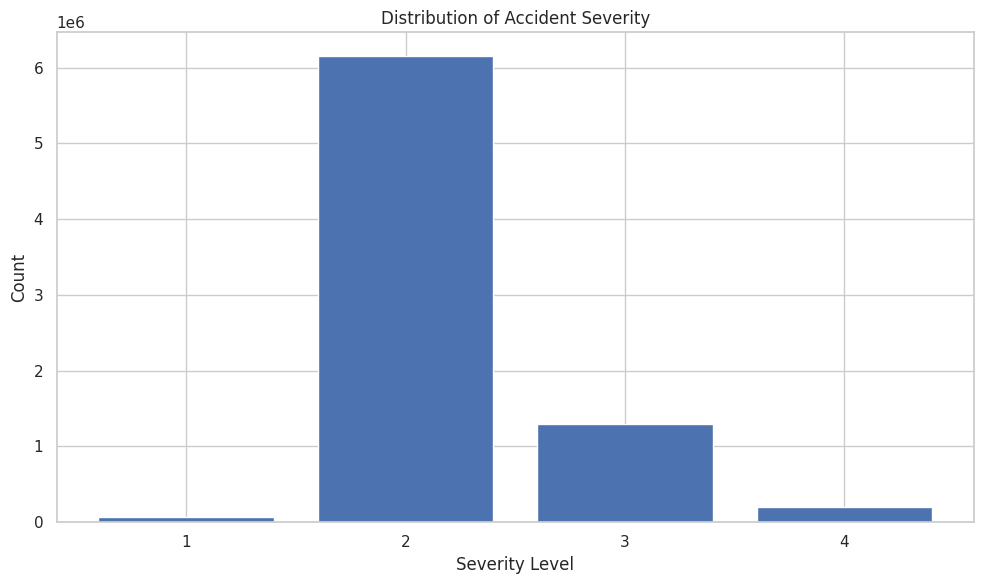

In [36]:
severity_counts = df_fe.groupBy("Severity").count().orderBy("Severity")
severity_pd = severity_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(severity_pd["Severity"].astype(str), severity_pd["count"])
plt.title("Distribution of Accident Severity")
plt.xlabel("Severity Level")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


## Temporal Analysis

### Hourly distribution

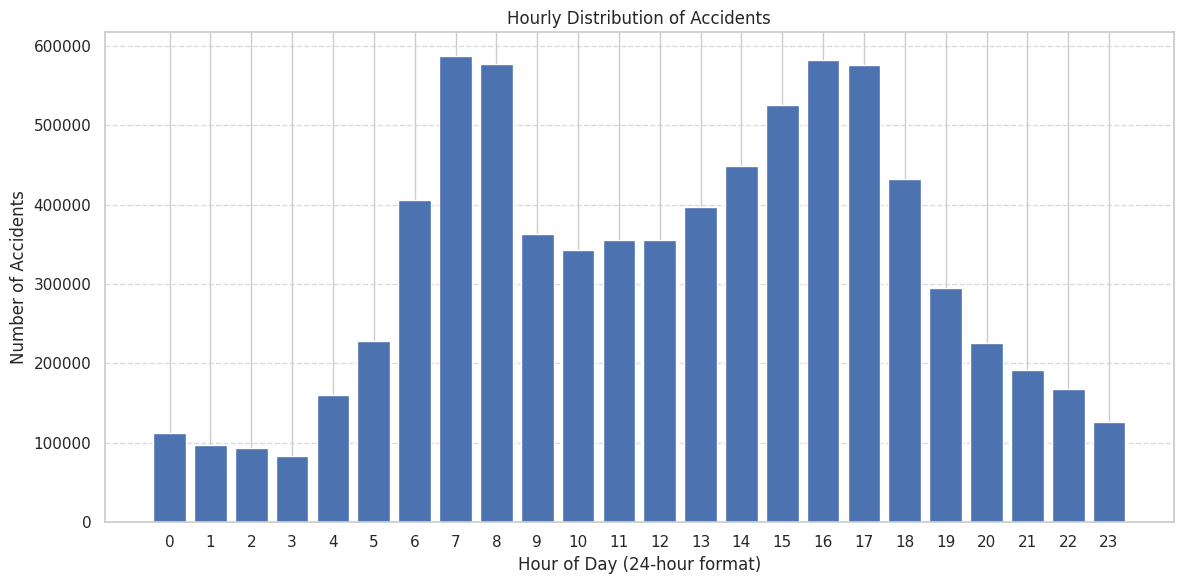

In [37]:
hourly_counts = df_fe.groupBy("Hour").count().orderBy("Hour")
hourly_pd = hourly_counts.toPandas()

plt.figure(figsize=(12, 6))
plt.bar(hourly_pd["Hour"], hourly_pd["count"])
plt.title("Hourly Distribution of Accidents")
plt.xlabel("Hour of Day (24-hour format)")
plt.ylabel("Number of Accidents")
plt.xticks(range(0, 24))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Day of week distribution

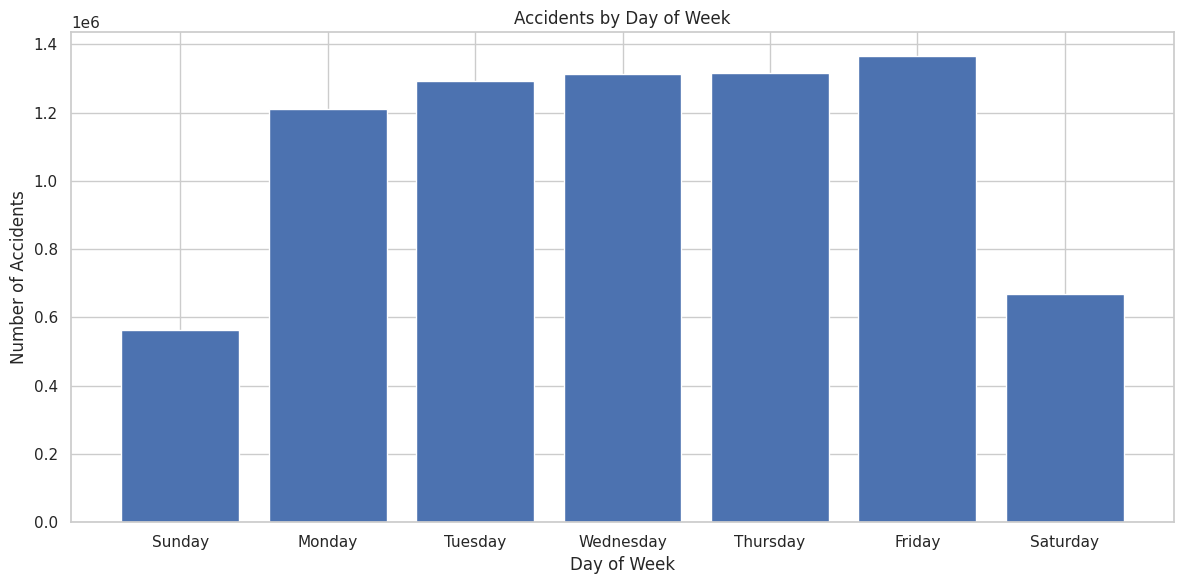

In [38]:
day_mapping = {1: "Sunday", 2: "Monday", 3: "Tuesday", 4: "Wednesday", 
               5: "Thursday", 6: "Friday", 7: "Saturday"}
               
day_counts = df_fe.groupBy("DayOfWeek").count().orderBy("DayOfWeek")
day_pd = day_counts.toPandas()
day_pd["DayName"] = day_pd["DayOfWeek"].map(day_mapping)

plt.figure(figsize=(12, 6))
plt.bar(day_pd["DayName"], day_pd["count"])
plt.title("Accidents by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

### Monthly distribution

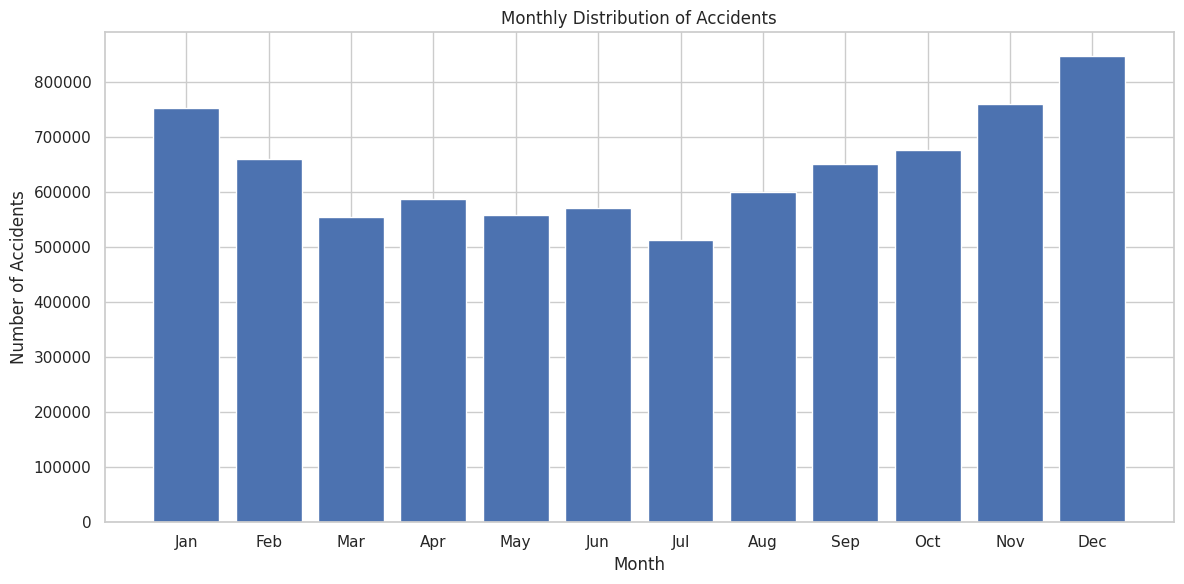

In [39]:
month_mapping = {1: "Jan", 2: "Feb", 3: "Mar", 4: "Apr", 5: "May", 6: "Jun",
                 7: "Jul", 8: "Aug", 9: "Sep", 10: "Oct", 11: "Nov", 12: "Dec"}
                 
month_counts = df_fe.groupBy("Month").count().orderBy("Month")
month_pd = month_counts.toPandas()
month_pd["MonthName"] = month_pd["Month"].map(month_mapping)

plt.figure(figsize=(12, 6))
plt.bar(month_pd["MonthName"], month_pd["count"])
plt.title("Monthly Distribution of Accidents")
plt.xlabel("Month")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

### Yearly trend

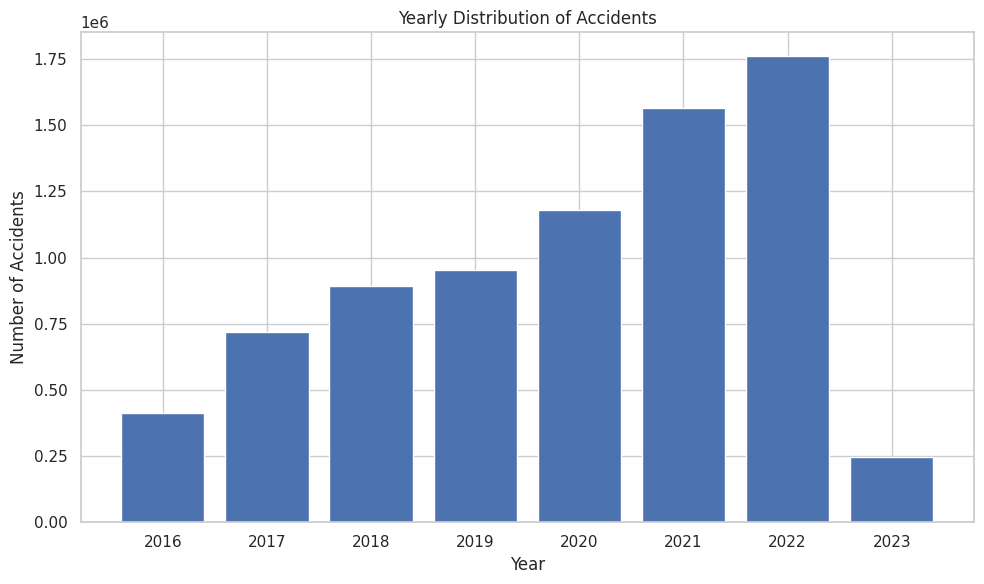

In [40]:
year_counts = df_fe.groupBy("Year").count().orderBy("Year")
year_pd = year_counts.toPandas()

plt.figure(figsize=(10, 6))
plt.bar(year_pd["Year"].astype(str), year_pd["count"])
plt.title("Yearly Distribution of Accidents")
plt.xlabel("Year")
plt.ylabel("Number of Accidents")
plt.tight_layout()
plt.show()

## Geographic Analysis

### Top 15 states with most accidents

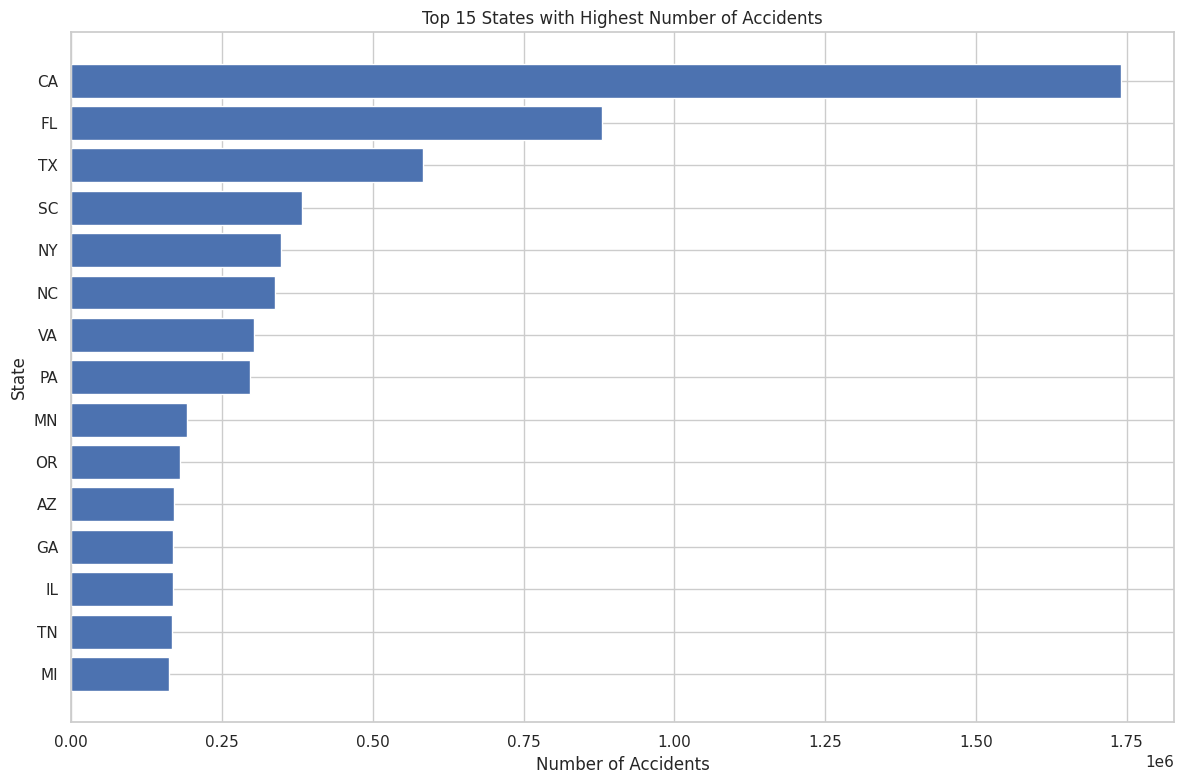

In [41]:
top_states = df_fe.groupBy("State").count().orderBy(desc("count")).limit(15)
top_states_pd = top_states.toPandas()

plt.figure(figsize=(12, 8))
plt.barh(top_states_pd["State"][::-1], top_states_pd["count"][::-1])
plt.title("Top 15 States with Highest Number of Accidents")
plt.xlabel("Number of Accidents")
plt.ylabel("State")
plt.tight_layout()
plt.show()


## Weather Condition Analysis

### Top weather conditions

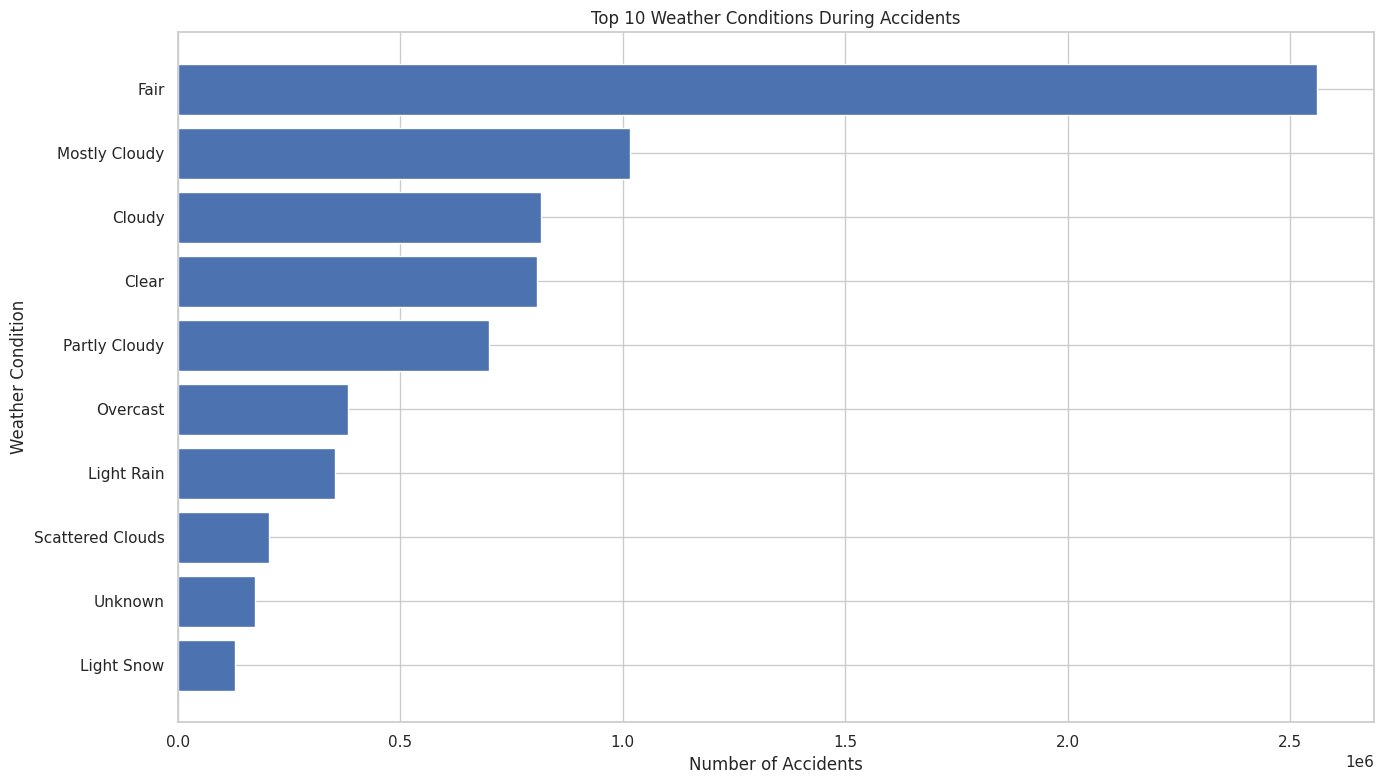

In [42]:
top_weather = df_fe.groupBy("Weather_Condition").count().orderBy(desc("count")).limit(10)
top_weather_pd = top_weather.toPandas()

plt.figure(figsize=(14, 8))
plt.barh(top_weather_pd["Weather_Condition"][::-1], top_weather_pd["count"][::-1])
plt.title("Top 10 Weather Conditions During Accidents")
plt.xlabel("Number of Accidents")
plt.ylabel("Weather Condition")
plt.tight_layout()
plt.show()

### Temperature distribution

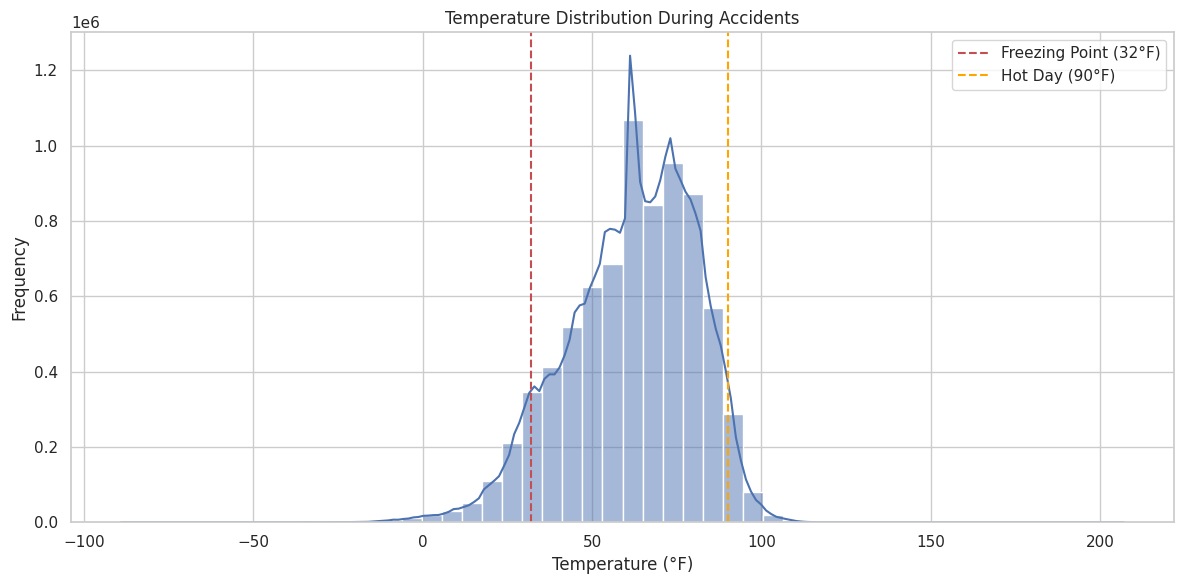

In [43]:
temp_data = df_fe.select("Temperature(F)").toPandas()

plt.figure(figsize=(12, 6))
sns.histplot(temp_data["Temperature(F)"], bins=50, kde=True)
plt.title("Temperature Distribution During Accidents")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.axvline(x=32, color='r', linestyle='--', label="Freezing Point (32°F)")
plt.axvline(x=90, color='orange', linestyle='--', label="Hot Day (90°F)")
plt.legend()
plt.tight_layout()
plt.show()

## Road Features Analysis

### Road feature impact

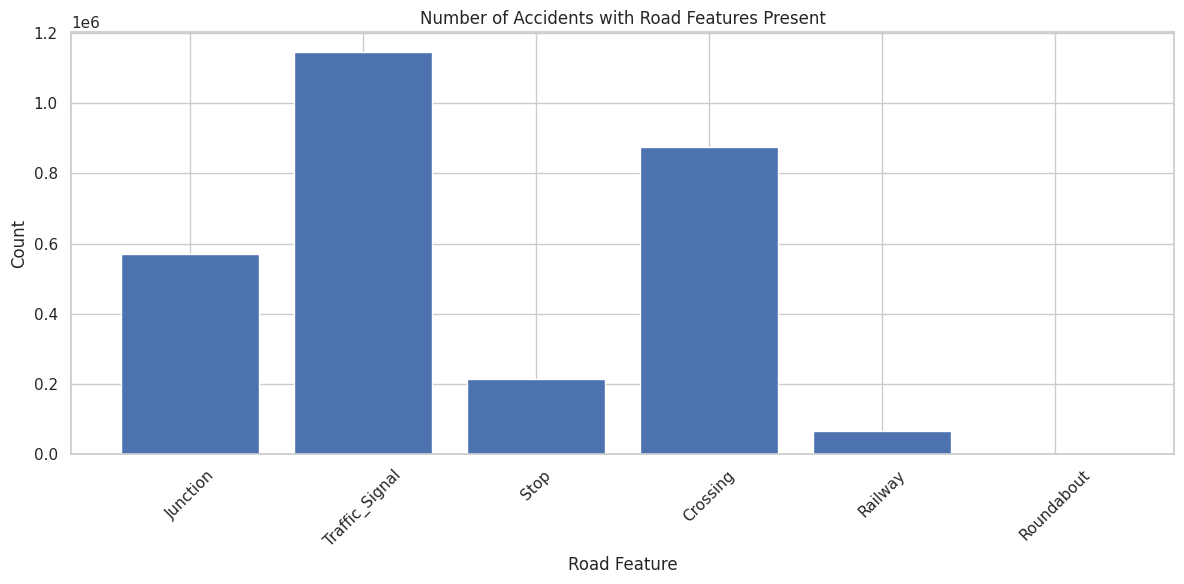

In [44]:
road_features = ["Junction", "Traffic_Signal", "Stop", "Crossing", "Railway", "Roundabout"]
feature_counts = {}

for feature in road_features:
    counts = df_fe.groupBy(feature).count().orderBy(feature).toPandas()
    if len(counts) == 2:  # Binary feature (0/1)
        feature_counts[feature] = counts.iloc[1]["count"]  # Count of "True" values

# Create bar chart of road features
plt.figure(figsize=(12, 6))
plt.bar(feature_counts.keys(), feature_counts.values())
plt.title("Number of Accidents with Road Features Present")
plt.xlabel("Road Feature")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Correlation Analysis

25/04/11 20:14:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


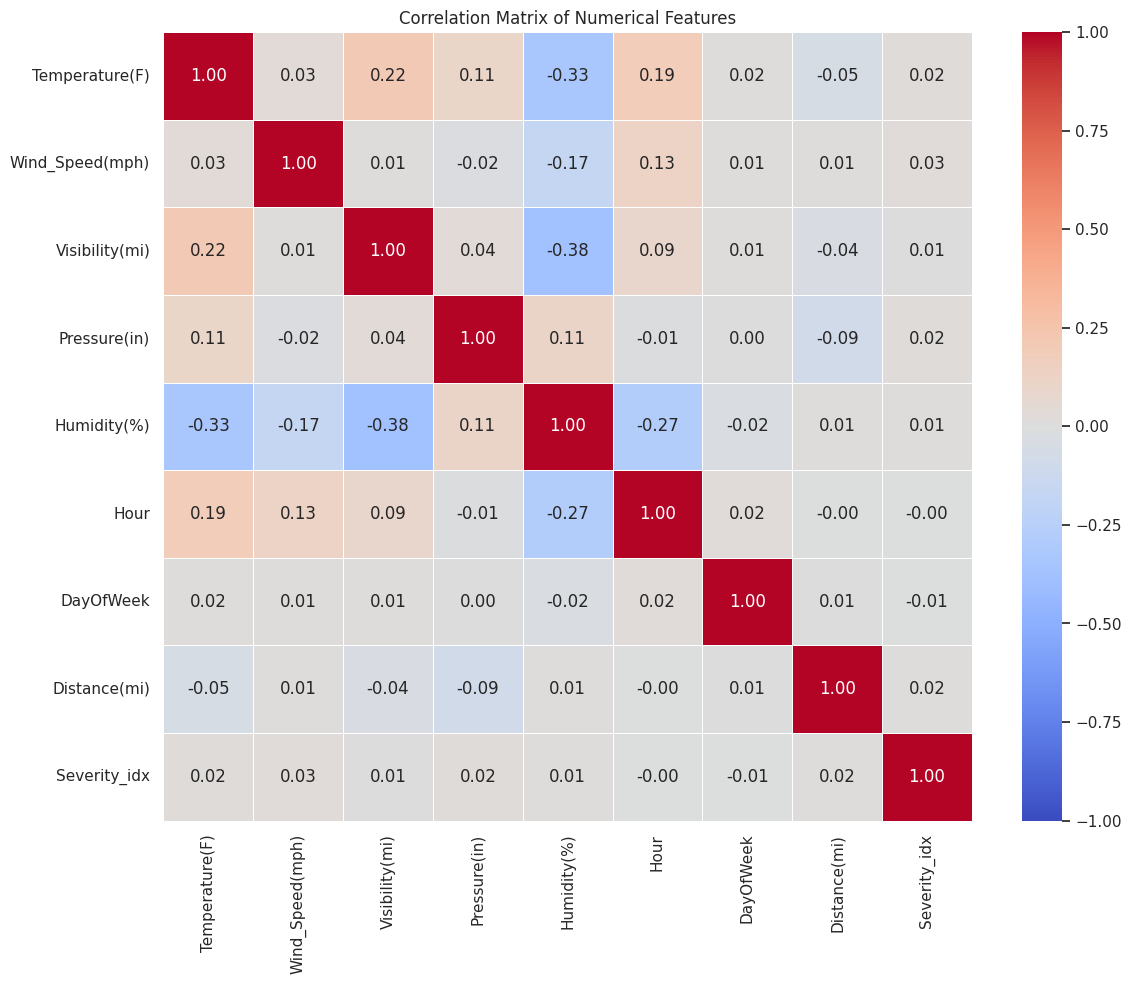

In [45]:
correlation_cols = ["Temperature(F)", "Wind_Speed(mph)", "Visibility(mi)", 
                    "Pressure(in)", "Humidity(%)", "Hour", "DayOfWeek", 
                    "Distance(mi)", "Severity_idx"]
correlation_assembler = VectorAssembler(
    inputCols=correlation_cols,
    outputCol="correlation_features",
    handleInvalid="skip"
)
correlation_df = correlation_assembler.transform(df_fe).select("correlation_features")

from pyspark.ml.stat import Correlation
correlation_matrix = Correlation.corr(correlation_df, "correlation_features").collect()[0][0]

# Convert Spark Matrix to numpy array
correlation_array = np.array(correlation_matrix.toArray())

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(
    correlation_array, 
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5, 
    vmin=-1, 
    vmax=1,
    xticklabels=correlation_cols,
    yticklabels=correlation_cols
)
plt.title("Correlation Matrix of Numerical Features")
plt.tight_layout()
plt.show()



## Severity Analysis by Feature

### Severity by time of day

<Figure size 1400x800 with 0 Axes>

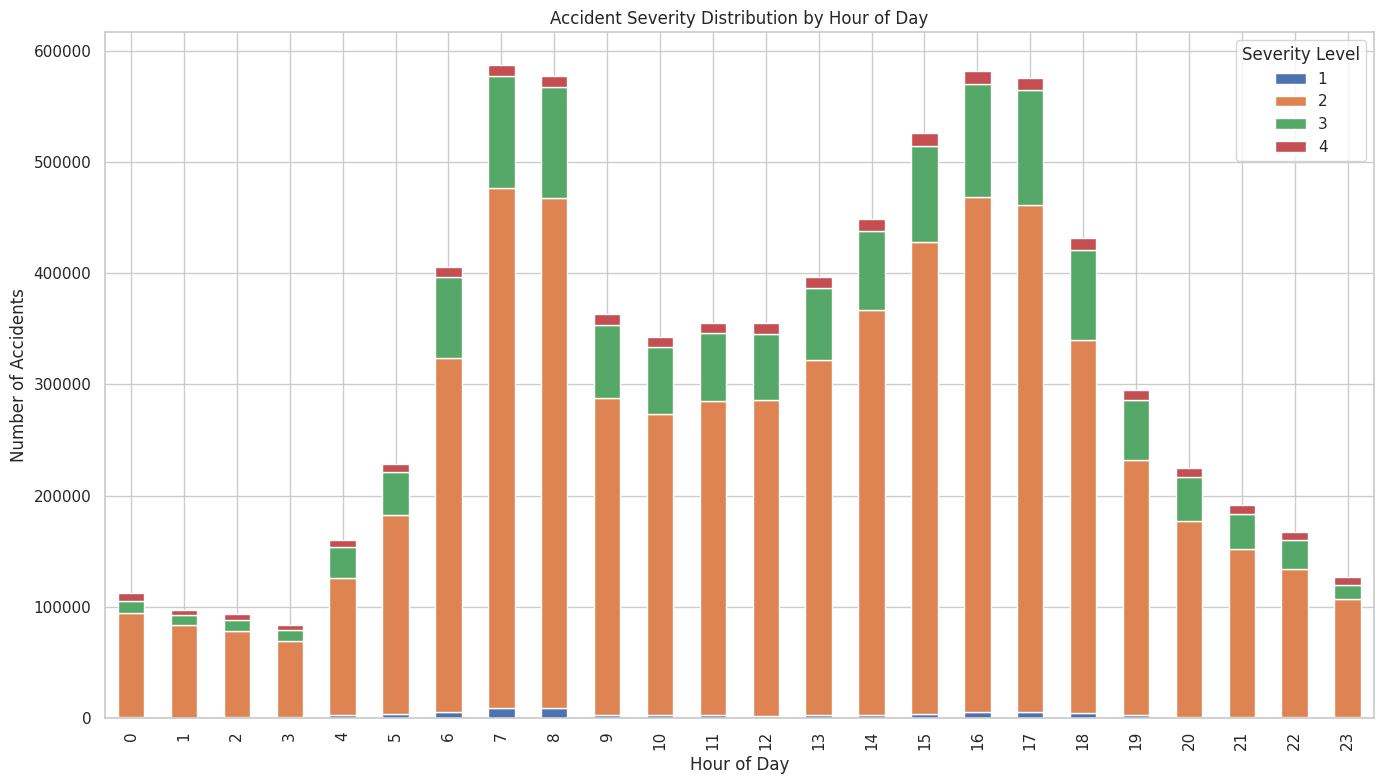

In [46]:
severity_by_hour = df_fe.groupBy("Hour", "Severity").count().orderBy("Hour", "Severity")
severity_hour_pd = severity_by_hour.toPandas()

# Pivot the data for stacked bar chart
severity_hour_pivot = severity_hour_pd.pivot(index="Hour", columns="Severity", values="count").fillna(0)

plt.figure(figsize=(14, 8))
severity_hour_pivot.plot(kind="bar", stacked=True, figsize=(14, 8))
plt.title("Accident Severity Distribution by Hour of Day")
plt.xlabel("Hour of Day")
plt.ylabel("Number of Accidents")
plt.legend(title="Severity Level")
plt.tight_layout()
plt.show()



## Analysis of Visibility and Its Impact

<Figure size 1000x600 with 0 Axes>

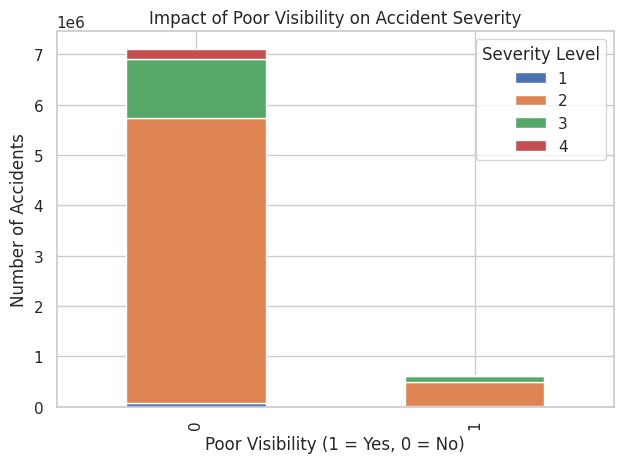

In [47]:
vis_severity = df_fe.groupBy("Poor_Visibility", "Severity").count().orderBy("Poor_Visibility", "Severity")
vis_severity_pd = vis_severity.toPandas()

# Create pivot table
vis_severity_pivot = vis_severity_pd.pivot(index="Poor_Visibility", columns="Severity", values="count").fillna(0)

plt.figure(figsize=(10, 6))
vis_severity_pivot.plot(kind="bar", stacked=True)
plt.title("Impact of Poor Visibility on Accident Severity")
plt.xlabel("Poor Visibility (1 = Yes, 0 = No)")
plt.ylabel("Number of Accidents")
plt.legend(title="Severity Level")
plt.tight_layout()
plt.show()

# Machine Training

In [48]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# 75% train, 15% eval, 10% validation
train_data, test_data, val_data = df_fe.randomSplit([0.75, 0.15, 0.10], seed=42)

# Print counts
print(f"Training set size: {train_data.count()}")
print(f"Test set size: {test_data.count()}")
print(f"Validation set size: {val_data.count()}")


Training set size: 5797231


Test set size: 1157896


Validation set size: 773267


In [49]:
label_indexer = StringIndexer(inputCol="Severity", outputCol="label", handleInvalid="keep")
feature_col = "features_engineered"

## PCA

In [50]:
from pyspark.ml.feature import PCA
n_components = 10
pca = PCA(inputCol=feature_col, outputCol="pca_features", k=n_components)

## Model Evaluator

In [52]:
def evaluate_model(predictions, name):
    # Initialize evaluator
    evaluator = MulticlassClassificationEvaluator(
        labelCol="label", 
        predictionCol="prediction"
    )
    
    # Accuracy
    evaluator.setMetricName("accuracy")
    accuracy = evaluator.evaluate(predictions)
    
    # Precision
    evaluator.setMetricName("weightedPrecision")
    precision = evaluator.evaluate(predictions)
    
    # Recall
    evaluator.setMetricName("weightedRecall")
    recall = evaluator.evaluate(predictions)
    
    # F1 score
    evaluator.setMetricName("f1")
    f1 = evaluator.evaluate(predictions)
    
    print(f"Model: {name}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("-------------------------------------")
    
    return accuracy, precision, recall, f1, predictions

## Training models with PCA

In [68]:
print("Training Logistic Regression model with PCA...")
lr = LogisticRegression(featuresCol="pca_features", labelCol="label", maxIter=10, regParam=0.1)
lr_pipeline = Pipeline(stages=[label_indexer, pca, lr])
lr_model = lr_pipeline.fit(train_data)
lr_predictions = lr_model.transform(test_data)
lr_metrics = evaluate_model(lr_predictions, "Logistic Regression with PCA")

Training Logistic Regression model with PCA...


In [69]:
lr_metrics = evaluate_model(lr_predictions, "Logistic Regression with PCA")
lr_metrics

Model: Logistic Regression with PCA
Accuracy: 0.7968
Precision: 0.6608
Recall: 0.7968
F1 Score: 0.7067
-------------------------------------


(0.7968280398239566,
 0.6608090076903217,
 0.7968280398239566,
 0.706738395977198,
 DataFrame[ID: string, Source: string, Severity: int, Start_Time: timestamp, End_Time: timestamp, Start_Lat: double, Start_Lng: double, End_Lat: double, End_Lng: double, Distance(mi): double, Description: string, Street: string, City: string, County: string, State: string, Zipcode: string, Country: string, Timezone: string, Airport_Code: string, Weather_Timestamp: timestamp, Temperature(F): double, Wind_Chill(F): double, Humidity(%): double, Pressure(in): double, Visibility(mi): double, Wind_Direction: string, Wind_Speed(mph): double, Precipitation(in): double, Weather_Condition: string, Amenity: boolean, Bump: boolean, Crossing: boolean, Give_Way: boolean, Junction: boolean, No_Exit: boolean, Railway: boolean, Roundabout: boolean, Station: boolean, Stop: boolean, Traffic_Calming: boolean, Traffic_Signal: boolean, Turning_Loop: boolean, Sunrise_Sunset: string, Civil_Twilight: string, Nautical_Twilight: s

In [67]:
print("Training Random Forest model with PCA...")
rf = RandomForestClassifier(featuresCol="pca_features", labelCol="label", numTrees=20, maxDepth=10)
rf_pipeline = Pipeline(stages=[label_indexer, pca, rf])
rf_model = rf_pipeline.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rf_metrics = evaluate_model(rf_predictions, "Random Forest with PCA")

Training Random Forest model with PCA...


25/04/11 22:36:44 WARN DAGScheduler: Broadcasting large task binary with size 1230.7 KiB
25/04/11 22:36:57 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/04/11 22:37:15 WARN DAGScheduler: Broadcasting large task binary with size 3.8 MiB
25/04/11 22:37:36 WARN DAGScheduler: Broadcasting large task binary with size 1101.9 KiB
25/04/11 22:37:38 WARN DAGScheduler: Broadcasting large task binary with size 1885.2 KiB
25/04/11 22:38:44 WARN DAGScheduler: Broadcasting large task binary with size 1885.2 KiB
25/04/11 22:39:49 WARN DAGScheduler: Broadcasting large task binary with size 1885.2 KiB
25/04/11 22:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1885.2 KiB


Model: Random Forest with PCA
Accuracy: 0.7971
Precision: 0.7418
Recall: 0.7971
F1 Score: 0.7079
-------------------------------------


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

print("Training Logistic Regression with Grid Search (Train/Validation Split)...")

lr = LogisticRegression(featuresCol="pca_features", 
                       labelCol="label",
                       family="multinomial")

lr_pipeline = Pipeline(stages=[label_indexer, pca, lr])

# Define parameter grid
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.1, 1.0])   # Regularization
             .addGrid(lr.maxIter, [100, 250, 1000])    # Iterations
             .build())

# Configure evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

# Set up train/validation split (not cross-validation)
tvs = TrainValidationSplit(
    estimator=lr_pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    # 90% training, 10% validation
    trainRatio=0.9,
    parallelism=4
)

# Fit with grid search
lr_model = tvs.fit(train_data)

# Get best model from grid search
best_model = lr_model.bestModel
print("Best parameters found:")
print(f"RegParam: {best_model.stages[-1].getRegParam()}")
print(f"MaxIter: {best_model.stages[-1].getMaxIter()}")

# Evaluate on test set
lr_predictions = best_model.transform(test_data)
lr_metrics = evaluate_model(lr_predictions, "Random Forest with PCA")

Training Logistic Regression with Grid Search (Train/Validation Split)...


25/04/11 17:40:05 WARN MemoryStore: Not enough space to cache rdd_4536_5 in memory! (computed 125.4 MiB so far)
25/04/11 17:40:05 WARN BlockManager: Persisting block rdd_4536_5 to disk instead.
25/04/11 17:40:05 WARN MemoryStore: Not enough space to cache rdd_4536_0 in memory! (computed 124.9 MiB so far)
25/04/11 17:40:05 WARN BlockManager: Persisting block rdd_4536_0 to disk instead.
25/04/11 17:40:07 WARN MemoryStore: Not enough space to cache rdd_4536_4 in memory! (computed 247.3 MiB so far)
25/04/11 17:40:07 WARN BlockManager: Persisting block rdd_4536_4 to disk instead.
25/04/11 17:40:07 WARN MemoryStore: Not enough space to cache rdd_4536_2 in memory! (computed 247.5 MiB so far)
25/04/11 17:40:07 WARN BlockManager: Persisting block rdd_4536_2 to disk instead.
25/04/11 17:40:07 WARN MemoryStore: Not enough space to cache rdd_4536_3 in memory! (computed 247.3 MiB so far)
25/04/11 17:40:07 WARN BlockManager: Persisting block rdd_4536_3 to disk instead.
25/04/11 17:40:12 WARN MemoryS

Best parameters found:
RegParam: 0.01
MaxIter: 100


Model: Random Forest with PCA
Accuracy: 0.7963
Precision: 0.7041
Recall: 0.7963
F1 Score: 0.7086
-------------------------------------


In [ ]:
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

print("Training Random Forest with PCA + Grid Search ...")

# Initialize model
rf = RandomForestClassifier(featuresCol="pca_features", labelCol="label")

# Create pipeline
rf_pipeline = Pipeline(stages=[label_indexer, pca, rf])

# Define parameter grid
param_grid = (ParamGridBuilder()
             .addGrid(rf.numTrees, [10, 20])
             .addGrid(rf.maxDepth, [10, 15])
             .build())

# Evaluator
evaluator = MulticlassClassificationEvaluator(
    labelCol="label",
    predictionCol="prediction",
    metricName="f1"
)

# Single train/validation split (no cross-validation)
tvs = TrainValidationSplit(
    estimator=rf_pipeline,
    estimatorParamMaps=param_grid,
    evaluator=evaluator,
    seed=42,
    parallelism=4        # Run 4 parameter sets in parallel
)

# Train on train_data (automatically splits into train/validation internally)
rf_model = tvs.fit(train_data)

# Evaluate on untouched test_data
rf_predictions = rf_model.transform(test_data)
rf_metrics = evaluate_model(rf_predictions, "Random Forest with Grid Search")

# Get the best RandomForest model from the pipeline
best_rf_model = rf_model.bestModel.stages[-1]

print("\nBest Parameters Found:")
print(f"• numTrees: {best_rf_model.getNumTrees}")
print(f"• maxDepth: {best_rf_model.getMaxDepth()}")

25/04/11 22:06:25 WARN MemoryStore: Not enough space to cache rdd_3265_21 in memory! (computed 124.7 MiB so far)
25/04/11 22:06:25 WARN MemoryStore: Not enough space to cache rdd_3265_19 in memory! (computed 126.1 MiB so far)
25/04/11 22:06:25 WARN MemoryStore: Not enough space to cache rdd_3265_7 in memory! (computed 125.3 MiB so far)
25/04/11 22:06:25 WARN MemoryStore: Not enough space to cache rdd_3265_9 in memory! (computed 64.6 MiB so far)
25/04/11 22:06:25 WARN MemoryStore: Not enough space to cache rdd_3265_8 in memory! (computed 246.9 MiB so far)
25/04/11 22:06:26 WARN MemoryStore: Not enough space to cache rdd_3265_6 in memory! (computed 429.3 MiB so far)
25/04/11 22:06:26 WARN MemoryStore: Not enough space to cache rdd_3265_12 in memory! (computed 126.3 MiB so far)
25/04/11 22:06:26 WARN MemoryStore: Not enough space to cache rdd_3265_6 in memory! (computed 246.9 MiB so far)
25/04/11 22:06:26 WARN MemoryStore: Not enough space to cache rdd_3265_13 in memory! (computed 126.3 M

Model: Random Forest with Grid Search
Accuracy: 0.8003
Precision: 0.7677
Recall: 0.8003
F1 Score: 0.7236
-------------------------------------

Best Parameters Found:
• numTrees: 10
• maxDepth: 15


25/04/11 22:12:16 WARN MemoryStore: Not enough space to cache rdd_3265_16 in memory! (computed 126.2 MiB so far)


25/04/11 22:12:16 WARN MemoryStore: Not enough space to cache rdd_3265_19 in memory! (computed 126.1 MiB so far)
25/04/11 22:12:16 WARN MemoryStore: Not enough space to cache rdd_3265_18 in memory! (computed 65.0 MiB so far)
25/04/11 22:12:16 WARN MemoryStore: Not enough space to cache rdd_3265_15 in memory! (computed 248.8 MiB so far)
25/04/11 22:12:17 WARN MemoryStore: Not enough space to cache rdd_3265_20 in memory! (computed 126.0 MiB so far)
25/04/11 22:12:17 WARN MemoryStore: Not enough space to cache rdd_3265_17 in memory! (computed 248.7 MiB so far)
25/04/11 22:12:18 WARN MemoryStore: Not enough space to cache rdd_3265_6 in memory! (computed 64.6 MiB so far)
25/04/11 22:12:18 WARN MemoryStore: Not enough space to cache rdd_3265_21 in memory! (computed 245.7 MiB so far)
25/04/11 22:12:18 WARN MemoryStore: Not enough space to cache rdd_3265_22 in memory! (computed 125.3 MiB so far)
25/04/11 22:12:18 WARN MemoryStore: Not enough space to cache rdd_3265_5 in memory! (computed 64.6 

In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.feature import VectorIndexer

num_features = len(df_fe.select(feature_col).first()[0])
num_classes = df_fe.select("Severity").distinct().count()

layers = [n_components, 32, num_classes]
# mlp = MultilayerPerceptronClassifier(
#     featuresCol=feature_col,
#     labelCol="label",
#     layers=layers,
#     blockSize=128,
#     seed=42,
#     maxIter=100
# )
mlp = MultilayerPerceptronClassifier(
    featuresCol="pca_features",  # Use PCA features
    labelCol="label",
    layers=layers,
    blockSize=64,  # Smaller batch size
    seed=42,
    maxIter=20,    # Fewer iterations
    tol=1e-4       # Less strict convergence
)

# mlp_pipeline = Pipeline(stages=[label_indexer, mlp])

In [ ]:
# print("Training Gradient Boosted Trees model with PCA...")
# gbt = GBTClassifier(featuresCol="pca_features", labelCol="label", maxIter=10, maxDepth=5)
# gbt_pipeline = Pipeline(stages=[label_indexer, pca, gbt])
# gbt_model = gbt_pipeline.fit(train_data)
# gbt_predictions = gbt_model.transform(test_data)
# gbt_metrics = evaluate_model(gbt_predictions, "Gradient Boosted Trees with PCA")

print("Training Multilayer Perceptron model...")


mlp_pipeline = Pipeline(stages=[pca, label_indexer, mlp])
mlp_model = mlp_pipeline.fit(train_data)
mlp_predictions = mlp_model.transform(test_data)
mlp_metrics = evaluate_model(mlp_predictions, "Multilayer Perceptron with PCA")


Training Multilayer Perceptron model...


Model: Multilayer Perceptron with PCA
Accuracy: 0.7171
Precision: 0.5142
Recall: 0.7171
F1 Score: 0.5989
-------------------------------------


### Best Model

In [ ]:
models = [("Logistic Regression", lr_model, lr_metrics), 
          ("Random Forest", rf_model, rf_metrics), 
          ("Multilayer Perceptron", mlp_model, mlp_metrics)]

best_model_name, best_model, best_metrics = max(models, key=lambda x: x[2][3])
best_predictions = best_metrics[4]
print(f"Best model: {best_model_name} with F1 score: {best_metrics[3]:.4f}")

Best model: Random Forest with F1 score: 0.6004


In [ ]:
pred_and_labels = best_predictions.select("prediction", "label")
confusion_matrix = pred_and_labels.groupBy("prediction").pivot("label").count().fillna(0)
print("Confusion Matrix:")
confusion_matrix.show()

Confusion Matrix:


25/04/11 11:58:04 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/04/11 11:58:36 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
25/04/11 11:58:36 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


+----------+------+------+-----+----+
|prediction|   0.0|   1.0|  2.0| 3.0|
+----------+------+------+-----+----+
|       0.0|650586|234797|13465|7848|
|       1.0|   272|   641|   55|   9|
+----------+------+------+-----+----+



### PCA components explained variance

In [ ]:
pca_model = lr_model.stages[1] 
variance = pca_model.explainedVariance
print("Explained variance by components:")
for i, v in enumerate(variance):
    print(f"PC {i+1}: {v:.4f}")
print(f"Total variance explained: {sum(variance):.4f}")

Explained variance by components:
PC 1: 0.4110
PC 2: 0.2957
PC 3: 0.2032
PC 4: 0.0272
PC 5: 0.0202
PC 6: 0.0135
PC 7: 0.0115
PC 8: 0.0063
PC 9: 0.0032
PC 10: 0.0021
Total variance explained: 0.9939


## Training w/o PCA

In [ ]:
print("Training Logistic Regression model...")
lr = LogisticRegression(featuresCol=feature_col, labelCol="label", maxIter=10, regParam=0.1)
lr_pipeline = Pipeline(stages=[label_indexer, lr])
lr_model = lr_pipeline.fit(train_data)
lr_predictions = lr_model.transform(test_data)
lr_metrics = evaluate_model(lr_predictions, "Logistic Regression without PCA")

Training Logistic Regression model...


Model: Logistic Regression without PCA
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000
-------------------------------------


In [ ]:
print("Training Random Forest model...")
rf = RandomForestClassifier(featuresCol=feature_col, labelCol="label", numTrees=20, maxDepth=10)
rf_pipeline = Pipeline(stages=[label_indexer, rf])
rf_model = rf_pipeline.fit(train_data)
rf_predictions = rf_model.transform(test_data)
rf_metrics = evaluate_model(rf_predictions, "Random Forest without PCA")

Training Random Forest model...


25/04/11 12:09:23 WARN MemoryStore: Not enough space to cache rdd_1950_0 in memory! (computed 147.0 MiB so far)
25/04/11 12:09:23 WARN BlockManager: Persisting block rdd_1950_0 to disk instead.
25/04/11 12:09:23 WARN MemoryStore: Not enough space to cache rdd_1950_1 in memory! (computed 98.0 MiB so far)
25/04/11 12:09:23 WARN BlockManager: Persisting block rdd_1950_1 to disk instead.
25/04/11 12:09:23 WARN MemoryStore: Not enough space to cache rdd_1950_2 in memory! (computed 147.0 MiB so far)
25/04/11 12:09:23 WARN BlockManager: Persisting block rdd_1950_2 to disk instead.
25/04/11 12:09:23 WARN MemoryStore: Not enough space to cache rdd_1950_4 in memory! (computed 147.0 MiB so far)
25/04/11 12:09:23 WARN BlockManager: Persisting block rdd_1950_4 to disk instead.
25/04/11 12:09:23 WARN MemoryStore: Not enough space to cache rdd_1950_3 in memory! (computed 147.0 MiB so far)
25/04/11 12:09:23 WARN BlockManager: Persisting block rdd_1950_3 to disk instead.
25/04/11 12:09:46 WARN MemorySt

Model: Random Forest without PCA
Accuracy: 0.9999
Precision: 0.9999
Recall: 0.9999
F1 Score: 0.9999
-------------------------------------


In [ ]:
print("Training Multilayer Perceptron model...")
# Get feature dimension for MLP layer configuration
num_features = len(df_fe.select(feature_col).first()[0])
num_classes = df_fe.select("Severity").distinct().count()

layers = [num_features, 64, 32, num_classes]

mlp = MultilayerPerceptronClassifier(
    featuresCol=feature_col,
    labelCol="label",
    layers=layers,
    blockSize=128,
    seed=42,
    maxIter=20,
    tol=1e-4
)

mlp_pipeline = Pipeline(stages=[label_indexer, mlp])
mlp_model = mlp_pipeline.fit(train_data)
mlp_predictions = mlp_model.transform(test_data)
mlp_metrics = evaluate_model(mlp_predictions, "Multilayer Perceptron without PCA")

Training Multilayer Perceptron model...


25/04/11 12:15:13 WARN MemoryStore: Not enough space to cache rdd_2116_3 in memory! (computed 29.8 MiB so far)
25/04/11 12:15:13 WARN BlockManager: Persisting block rdd_2116_3 to disk instead.
25/04/11 12:15:13 WARN MemoryStore: Not enough space to cache rdd_2116_5 in memory! (computed 166.2 MiB so far)
25/04/11 12:15:13 WARN BlockManager: Persisting block rdd_2116_5 to disk instead.
25/04/11 12:15:13 WARN MemoryStore: Not enough space to cache rdd_2116_2 in memory! (computed 166.2 MiB so far)
25/04/11 12:15:13 WARN BlockManager: Persisting block rdd_2116_2 to disk instead.
25/04/11 12:15:13 WARN MemoryStore: Not enough space to cache rdd_2116_0 in memory! (computed 250.8 MiB so far)
25/04/11 12:15:13 WARN BlockManager: Persisting block rdd_2116_0 to disk instead.
25/04/11 12:15:13 WARN MemoryStore: Not enough space to cache rdd_2116_4 in memory! (computed 166.2 MiB so far)
25/04/11 12:15:13 WARN BlockManager: Persisting block rdd_2116_4 to disk instead.
25/04/11 12:15:13 WARN MemorySt

Model: Multilayer Perceptron without PCA
Accuracy: 0.7171
Precision: 0.5142
Recall: 0.7171
F1 Score: 0.5989
-------------------------------------


### Best Model

In [ ]:
models = [("Logistic Regression", lr_model, lr_metrics), 
          ("Random Forest", rf_model, rf_metrics), 
          ("Multilayer Perceptron", mlp_model, mlp_metrics)]


best_model_name, best_model, best_metrics = max(models, key=lambda x: x[2][3])
best_predictions = best_metrics[4]
print(f"Best model: {best_model_name} with F1 score: {best_metrics[3]:.4f}")

Best model: Logistic Regression with F1 score: 1.0000


In [ ]:
pred_and_labels = best_predictions.select("prediction", "label")
confusion_matrix = pred_and_labels.groupBy("prediction").pivot("label").count().fillna(0)
print("Confusion Matrix:")
confusion_matrix.show()

Confusion Matrix:


+----------+------+------+-----+----+
|prediction|   0.0|   1.0|  2.0| 3.0|
+----------+------+------+-----+----+
|       0.0|650856|     1|    0|   0|
|       1.0|     0|235437|    0|   0|
|       3.0|     0|     0|    0|7857|
|       2.0|     2|     0|13520|   0|
+----------+------+------+-----+----+



### model validation

In [ ]:
lr_predictions = lr_model.transform(test_data)
lr_metrics = evaluate_model(lr_predictions, "Logistic Regression with PCA")

In [ ]:
rf_predictions = rf_model.transform(test_data)
rf_metrics = evaluate_model(rf_predictions, "Random Forest with PCA")